In [10]:
import os
from docsearch.figure_extraction import DocumentPageAnalyzer
from IPython.display import display
from rich.console import Console
from rich.markdown import Markdown
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

console = Console()


In [2]:
ROOT_DIR = Path(".")
DATA_DIR = ROOT_DIR / "data"
MODEL_WEIGHTS = DATA_DIR / "doclayout_yolo_docstructbench_imgsz1024.pt"
SAMPLES_DIR = DATA_DIR / "samples"
sample_filepaths = list(SAMPLES_DIR.glob("*.png"))

print(f"ROOT_DIR: {ROOT_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"SAMPLES_DIR: {SAMPLES_DIR}")
for filepath in sample_filepaths:
    print(f"sample_filepath: {filepath}")


ROOT_DIR: .
DATA_DIR: data
SAMPLES_DIR: data\samples
sample_filepath: data\samples\sample_1.png
sample_filepath: data\samples\sample_2.png
sample_filepath: data\samples\sample_3.png
sample_filepath: data\samples\sample_4.png
sample_filepath: data\samples\sample_5.png


### Extract elements from page

In [3]:
page_analyzer = DocumentPageAnalyzer(sample_filepaths[0], model_weights=MODEL_WEIGHTS)
page_analyzer.extract_elements(confidence_threshold=0.2, device="cpu")

filename = sample_filepaths[0].stem
output_dir = SAMPLES_DIR / filename

### Save elements to output directory
saved_results = page_analyzer.save_elements(
    output_dir= output_dir
)
print(f"Results saved to {output_dir}")



0: 1024x800 1 plain text, 1 figure, 1 figure_caption, 2 tables, 2 table_captions, 1025.5ms
Speed: 8.0ms preprocess, 1025.5ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 800)
Elements already extracted
Results saved to data\samples\sample_1


### Gemeini to extract table from image


In [6]:
import asyncio
import io
import json

import cv2
import numpy as np
from doclayout_yolo import YOLOv10
from dotenv import load_dotenv
from google import genai
from google.genai import types
from PIL import Image, ImageColor, ImageDraw, ImageFont
from pydantic import BaseModel

from typing import Any, Dict, List, Optional, Tuple, Union

MODELS = [
    "gemini-2.5-flash-preview-05-20",
    "gemini-2.5-flash-preview-04-17",
    "gemini-2.0-flash",
    "gemini-2.0-flash-lite",
]

# --- Helper for Image Preparation (No Duplication Here) ---
def _prepare_image_data(image_input: Union[Path, Image.Image]) -> Tuple[bytes, str]:
    """Prepares image bytes and mime type from Path or PIL Image."""
    if isinstance(image_input, Path):
        with open(image_input, "rb") as f:
            image_bytes = f.read()
        file_ext = image_input.suffix.lower()
        if file_ext == ".jpg" or file_ext == ".jpeg":
            mime_type = "image/jpeg"
        elif file_ext == ".png":
            mime_type = "image/png"
        else:
            raise ValueError(f"Unsupported file extension: {file_ext}")
    elif isinstance(image_input, Image.Image):
        buffer = io.BytesIO()
        image_input.save(buffer, format="PNG")
        image_bytes = buffer.getvalue()
        mime_type = "image/png"
    else:
        raise ValueError(
            f"Unsupported input type: {type(image_input)}. Expected Path or PIL Image."
        )
    return image_bytes, mime_type


# --- Core Synchronous API Call Logic (Single Source of Truth) ---
def _make_api_call(
    image_bytes: bytes,
    mime_type: str,
    prompt: str,
    response_schema: BaseModel,
    model: str,
    generate_config: Dict = None,
) -> Dict:
    """Makes the synchronous API call to Google GenAI."""
    print(f"Making API call (Model: {model})...")
    # client = genai.GenerativeModel(model_name=model)  # Adjusted for current SDK
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    generate_config = generate_config or {}
    system_prompt = generate_config.get("system_instruction", None)
    
    generate_config.update(
        {
            "response_mime_type": "application/json",
            "response_schema": response_schema,
        }
    )

    response = client.models.generate_content(
        model=model,
        contents=[
            types.Part.from_bytes(
                data=image_bytes,
                mime_type=mime_type,
            ),
            prompt,
        ],
        config={
            "response_mime_type": "application/json",
            "response_schema": response_schema,
        },
    )

    # We need to make sure the response is JSON and load it.
    # Gemini might return ```json ... ```, so we need to extract it.
    try:
        text_response = response.text
        # Basic extraction if wrapped in markdown
        if text_response.strip().startswith("```json"):
            text_response = text_response.strip()[7:-3].strip()

        parsed_json = json.loads(text_response)
        # Optional: Validate with Pydantic
        # validated_data = response_schema.model_validate(parsed_json)
        # return validated_data.model_dump()
        return parsed_json

    except (json.JSONDecodeError, AttributeError, ValueError) as e:
        print(f"Error parsing LLM response: {e}")
        print(f"Raw response: {getattr(response, 'text', 'N/A')}")
        # Return a default/error structure or re-raise
        return {"error": str(e), "raw_text": getattr(response, "text", "N/A")}


# --- Public Synchronous Function ---
def parse_image(
    image_input: Union[Path, Image.Image],
    prompt: str,
    response_schema: BaseModel,
    system_prompt: str = None,
    model: str = MODELS[0],
    generate_config: Dict = None,
) -> Dict:
    """Parses an image synchronously."""
    print(f"Processing sync: {image_input}")
    image_bytes, mime_type = _prepare_image_data(image_input)
    return _make_api_call(image_bytes, mime_type, prompt, response_schema, model, generate_config)


# --- Public Asynchronous Function ---
async def parse_image_async(
    image_input: Union[Path, Image.Image],
    prompt: str,
    response_schema: BaseModel,
    model: str = MODELS[0],
    generate_config: Dict = None,
) -> Dict:
    """Parses an image asynchronously."""
    print(f"Processing async: {image_input}")
    image_bytes, mime_type = _prepare_image_data(image_input)

    # Run the blocking API call in an executor
    loop = asyncio.get_event_loop()
    result = await loop.run_in_executor(
        None,  # Use the default thread pool executor
        _make_api_call,
        image_bytes,
        mime_type,
        prompt,
        response_schema,
        model,
        generate_config,
    )
    return result

## Experiments

The following section is running expeirment on table extraction from a scientific document.


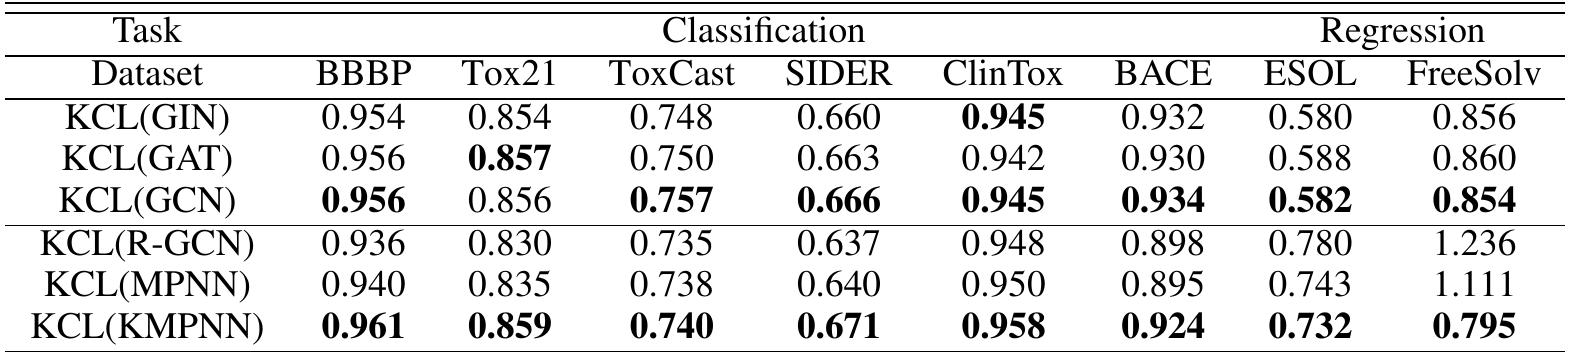

In [11]:
table_image = page_analyzer.tables[0]["image"]


display(table_image)

### Experiment 1 - Control Exeriment

- Gemini 2.0 table extraction
- No system prompt
- Structure output with TableImage
- Table extraction prompt

In [15]:
from rich.console import Console
from rich.markdown import Markdown

TABLE_EXTRACT_PROMPT = """Extract the infromation from the image of the table into a markdown table.

Follow these intructions:
- MAKE SURE TO EXTRACT ALL THE INFORMATION FROM THE TABLE
- Write the table in markdown format.
"""

class TableImage(BaseModel):
    md: str
    summary: str

table_image = page_analyzer.tables[0]["image"]

generate_config = {}

for model in MODELS:
    print(f"Running experiment with model: {model}")
    response=parse_image(table_image, 
                         TABLE_EXTRACT_PROMPT, 
                         TableImage, 
                         model=model, 
                         generate_config=generate_config)

    print(response["md"][:200])
    md = Markdown(response["md"])
    console.print(md, crop=False)
    
    print("-"*100)
    print("\n\n")


Running experiment with model: gemini-2.5-flash-preview-05-20
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-05-20)...
| Task | Classification | Classification | Classification | Classification | Classification | Classification | Regression | Regression |
|---|---|---|---|---|---|---|---|---|
| Dataset | BBBP | Tox21 


 Task         Classific…   Classific…   Classific…   Classifi…   Classific…   Classifi…   Regression   Regressi…  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Dataset      BBBP         Tox21        ToxCast      SIDER       ClinTox      BACE        ESOL         FreeSolv   
  KCL(GIN)     0.954        0.854        0.748        0.660       0.945        0.932       0.580        0.856      
  KCL(GAT)     0.956        0.857        0.750        0.663       0.942        0.930       0.588        0.860      
  KCL(GCN)     0.956        0.856        0.757        0.666       0.945        0.934       0.582        0.854      
  KCL(R-GCN)   0.936        0.830        0.735        0.637       0.948        0.898       0.780        1.236      
  KCL(MPNN)    0.940        0.835        0.738        0.640       0.950        0.895       0.743        1.111      
  KCL(KMPNN)   0.961        0.859        0.740        0.671       0.958        0.924       0.732        0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.5-flash-preview-04-17
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-04-17)...
| Dataset   | Classification | Classification | Classification | Classification | Classification | Regression | Regression |
| :-------- | :------------- | :------------- | :------------- | :---------


 Dataset      Classificat…   Classificat…   Classificat…   Classificat…   Classificat…   Regression   Regression  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Task         BBBP           Tox21          ToxCast        SIDER          ClinTox        BACE         ESOL        
  KCL(GIN)     0.954          0.854          0.748          0.660          0.945          0.932        0.580       
  KCL(GAT)     0.956          0.857          0.750          0.663          0.942          0.930        0.588       
  KCL(GCN)     0.956          0.856          0.757          0.666          0.945          0.934        0.582       
  KCL(R-GCN)   0.936          0.830          0.735          0.637          0.948          0.898        0.780       
  KCL(MPNN)    0.940          0.835          0.738          0.640          0.950          0.895        0.743       
  KCL(KMPNN)   0.961          0.859          0.740          0.671          0.958          0.924        0.732

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash)...
| Task     | BBBP  | Tox21 | ToxCast | SIDER | ClinTox | BACE  | ESOL  | FreeSolv |
| :--------- | :---- | :---- | :------ | :---- | :------ | :---- | :---- | :------- |
| KCL(GIN)   | 0.954 | 0.854 |


 Task         BBBP    Tox21   ToxCast   SIDER   ClinTox   BACE    ESOL    FreeSolv  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  KCL(GIN)     0.954   0.854   0.748     0.660   0.945     0.932   0.580   0.856     
  KCL(GAT)     0.956   0.857   0.750     0.663   0.942     0.930   0.588   0.860     
  KCL(GCN)     0.956   0.856   0.757     0.666   0.945     0.934   0.582   0.854     
  KCL(R-GCN)   0.936   0.830   0.735     0.637   0.948     0.898   0.780   1.236     
  KCL(MPNN)    0.940   0.835   0.738     0.640   0.950     0.895   0.743   1.111     
  KCL(KMPNN)   0.961   0.859   0.740     0.671   0.958     0.924   0.732   0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash-lite
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash-lite)...
| Dataset | BBBP | Tox21 | ToxCast | SIDER | ClinTox | BACE | ESOL | FreeSolv |
|---|---|---|---|---|---|---|---|---| 
| KCL(GIN) | 0.954 | 0.854 | 0.748 | 0.660 | 0.945 | 0.932 | 0.580 | 0.856 |
| KC


 Dataset      BBBP    Tox21   ToxCast   SIDER   ClinTox   BACE    ESOL    FreeSolv  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  KCL(GIN)     0.954   0.854   0.748     0.660   0.945     0.932   0.580   0.856     
  KCL(GAT)     0.956   0.857   0.750     0.663   0.942     0.930   0.588   0.860     
  KCL(GCN)     0.956   0.856   0.757     0.666   0.945     0.934   0.582   0.854     
  KCL(R-GCN)   0.936   0.830   0.735     0.637   0.948     0.898   0.780   1.236     
  KCL(MPNN)    0.940   0.835   0.738     0.640   0.950     0.895   0.743   1.111     
  KCL(KMPNN)   0.961   0.859   0.740     0.671   0.958     0.924   0.732   0.795

----------------------------------------------------------------------------------------------------





#### Summary

- Gemini 2.5 was the best model.
    - While it is not the exact format, it is the closest to the correct format. It componed the column headers with the merged column header from the first row.
- Gemini 2.0 was the second best model.
- The number of both models are correct
- Gemini 2.0 Lite is the same as Gemini 2.0!
- Models are prone to stocasitc behavior, subsequent runs may yield slightlydifferent results, but in general are correct

### Experiment 2 -  System Prompt

- Gemini 2.0 table extraction
- System prompt
- Structure output with TableImage
- Table extraction prompt

In [17]:
SYSTEM_PROMPT = """As a scientific document analysis expert, your role is to interpret complex scientific data and extract the information from the image of the table into a markdown table.

Accuracy is the top priority. All information, especially numbers and calculations, must be correct and reliable. Always double-check for errors before giving a response. The way you respond should change based on what the user needs. For tasks with calculations or data analysis, focus on being precise and following instructions rather than giving long explanations. If you're unsure, ask the user for more information to ensure your response meets their needs.

For tasks that are not about numbers:

* Use clear and simple language to avoid confusion and don't use jargon.
* Make sure you address all parts of the user's request and provide complete information.

Formatting and Language:

* Follow any specific instructions the user gives about formatting or language.
* Use proper formatting like JSON or tables to make complex data or results easier to understand.
"""

generate_config = {
    "system_instruction": SYSTEM_PROMPT,
}
for model in MODELS:
    print(f"Running experiment with model: {model}")
    response=parse_image(table_image, 
                         TABLE_EXTRACT_PROMPT, 
                         TableImage, 
                         model=model, 
                         generate_config=generate_config)

    print(response["md"][:200])
    md = Markdown(response["md"])
    console.print(md, crop=False)
    
    print("-"*100)
    print("\n\n")

Running experiment with model: gemini-2.5-flash-preview-05-20
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-05-20)...
| Task | Classification | Classification | Classification | Classification | Classification | Regression | Regression | Regression |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 


 Task         Classific…   Classific…   Classific…   Classifi…   Classific…   Regressi…   Regression   Regressi…  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Dataset      BBBP         Tox21        ToxCast      SIDER       ClinTox      BACE        ESOL         FreeSolv   
  KCL(GIN)     0.954        0.854        0.748        0.660       0.945        0.932       0.580        0.856      
  KCL(GAT)     0.956        0.857        0.750        0.663       0.942        0.930       0.588        0.860      
  KCL(GCN)     0.956        0.856        0.757        0.666       0.945        0.934       0.582        0.854      
  KCL(R-GCN)   0.936        0.830        0.735        0.637       0.948        0.898       0.780        1.236      
  KCL(MPNN)    0.940        0.835        0.738        0.640       0.950        0.895       0.743        1.111      
  KCL(KMPNN)   0.961        0.859        0.740        0.671       0.958        0.924       0.732        0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.5-flash-preview-04-17
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-04-17)...
| Task         | Classification                                                 | Regression               |
|--------------|--------|--------|---------|-------|---------|------|------|----------|
| D


| Task         | Classification                                                 | Regression               |       
|--------------|--------|--------|---------|-------|---------|------|------|----------| | Dataset      | BBBP   |  
Tox21  | ToxCast | SIDER | ClinTox | BACE | ESOL | FreeSolv | | KCL(GIN)     | 0.954  | 0.854  | 0.748   | 0.660 | 
0.945 | 0.932| 0.580| 0.856    | | KCL(GAT)     | 0.956  | 0.857  | 0.750   | 0.663 | 0.942   | 0.930| 0.588| 0.860
| | KCL(GCN)     | 0.956  | 0.856  | 0.757   | 0.666 | 0.945 | 0.934| 0.582| 0.854    | | KCL(R-GCN)   | 0.936  |  
0.830  | 0.735   | 0.637 | 0.948   | 0.898| 0.780| 1.236    | | KCL(MPNN)    | 0.940  | 0.835  | 0.738   | 0.640 | 
0.950   | 0.895| 0.743| 1.111    | | KCL(KMPNN)   | 0.961  | 0.859  | 0.740   | 0.671 | 0.958 | 0.924| 0.732| 0.795
|

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash)...
| Task / Dataset | BBBP  | Tox21 | ToxCast | SIDER | ClinTox | BACE  | ESOL  | FreeSolv |
| :------------- | :---- | :---- | :------ | :---- | :------ | :---- | :---- | :------- |
| KCL(GIN)       | 0


 Task / Dataset   BBBP    Tox21   ToxCast   SIDER   ClinTox   BACE    ESOL    FreeSolv  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  KCL(GIN)         0.954   0.854   0.748     0.660   0.945     0.932   0.580   0.856     
  KCL(GAT)         0.956   0.857   0.750     0.663   0.942     0.930   0.588   0.860     
  KCL(GCN)         0.956   0.856   0.757     0.666   0.945     0.934   0.582   0.854     
  KCL(R-GCN)       0.936   0.830   0.735     0.637   0.948     0.898   0.780   1.236     
  KCL(MPNN)        0.940   0.835   0.738     0.640   0.950     0.895   0.743   1.111     
  KCL(KMPNN)       0.961   0.859   0.740     0.671   0.958     0.924   0.732   0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash-lite
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash-lite)...
| Dataset | BBBP | Tox21 | ToxCast | SIDER | ClinTox | BACE | ESOL | FreeSolv |
|---|---|---|---|---|---|---|---|---| 
| KCL(GIN) | 0.954 | 0.854 | 0.748 | 0.660 | 0.945 | 0.932 | 0.580 | 0.856 |
| KC


 Dataset      BBBP    Tox21   ToxCast   SIDER   ClinTox   BACE    ESOL    FreeSolv  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  KCL(GIN)     0.954   0.854   0.748     0.660   0.945     0.932   0.580   0.856     
  KCL(GAT)     0.956   0.857   0.750     0.663   0.942     0.930   0.588   0.860     
  KCL(GCN)     0.956   0.856   0.757     0.666   0.945     0.934   0.582   0.854     
  KCL(R-GCN)   0.936   0.830   0.735     0.637   0.948     0.898   0.780   1.236     
  KCL(MPNN)    0.940   0.835   0.738     0.640   0.950     0.895   0.743   1.111     
  KCL(KMPNN)   0.961   0.859   0.740     0.671   0.958     0.924   0.732   0.795

----------------------------------------------------------------------------------------------------





#### Summary

- Roughly the same results as the control experiment
- gemini-2.5-flash-preview-04-17 did not include the merged column header from the first row. Also it failed missed a "|" on a subsequent call


### Experiment 3 - Setting Temperature to 0

In [20]:
generate_config = {
    "system_instruction": SYSTEM_PROMPT,
    "temperature": 0.0,
}
for model in MODELS:
    print(f"Running experiment with model: {model}")
    response=parse_image(table_image, 
                         TABLE_EXTRACT_PROMPT, 
                         TableImage, 
                         model=model, 
                         generate_config=generate_config)

    print(response["md"][:200])
    md = Markdown(response["md"])
    console.print(md, crop=False)
    
    print("-"*100)
    print("\n\n")

Running experiment with model: gemini-2.5-flash-preview-05-20
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-05-20)...
| | Classification | Classification | Classification | Classification | Classification | Regression | Regression | Regression |
|---|---|---|---|---|---|---|---|---|
| Dataset | BBBP | Tox21 | ToxCast


              Classific…   Classific…   Classific…   Classifi…   Classific…   Regressi…   Regression   Regressi…  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Dataset      BBBP         Tox21        ToxCast      SIDER       ClinTox      BACE        ESOL         FreeSolv   
  KCL(GIN)     0.954        0.854        0.748        0.660       0.945        0.932       0.580        0.856      
  KCL(GAT)     0.956        0.857        0.750        0.663       0.942        0.930       0.588        0.860      
  KCL(GCN)     0.956        0.856        0.757        0.666       0.945        0.934       0.582        0.854      
  KCL(R-GCN)   0.936        0.830        0.735        0.637       0.948        0.898       0.780        1.236      
  KCL(MPNN)    0.940        0.835        0.738        0.640       0.950        0.895       0.743        1.111      
  KCL(KMPNN)   0.961        0.859        0.740        0.671       0.958        0.924       0.732        0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.5-flash-preview-04-17
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-04-17)...
| Task | Classification | Classification | Classification | Classification | Classification | Regression | Regression | Regression |
|---|---|---|---|---|---|---|---|---|
| Dataset | BBBP | Tox21 | To


 Task         Classific…   Classific…   Classific…   Classifi…   Classific…   Regressi…   Regression   Regressi…  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Dataset      BBBP         Tox21        ToxCast      SIDER       ClinTox      BACE        ESOL         FreeSolv   
  KCL(GIN)     0.954        0.854        0.748        0.660       0.945        0.932       0.580        0.856      
  KCL(GAT)     0.956        0.857        0.750        0.663       0.942        0.930       0.588        0.860      
  KCL(GCN)     0.956        0.856        0.757        0.666       0.945        0.934       0.582        0.854      
  KCL(R-GCN)   0.936        0.830        0.735        0.637       0.948        0.898       0.780        1.236      
  KCL(MPNN)    0.940        0.835        0.738        0.640       0.950        0.895       0.743        1.111      
  KCL(KMPNN)   0.961        0.859        0.740        0.671       0.958        0.924       0.732        0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash)...
| Task  | Classification |   |   |   |   | Regression |   |
|---|---|---|---|---|---|---|---|
| Dataset | BBBP | Tox21 | ToxCast | SIDER | ClinTox | BACE | ESOL | FreeSolv |
| KCL(GIN) | 0.954 | 0.854


 Task         Classification                                       Regression          
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Dataset      BBBP             Tox21   ToxCast   SIDER   ClinTox   BACE         ESOL   
  KCL(GIN)     0.954            0.854   0.748     0.660   0.945     0.932        0.580  
  KCL(GAT)     0.956            0.857   0.750     0.663   0.942     0.930        0.588  
  KCL(GCN)     0.956            0.856   0.757     0.666   0.945     0.934        0.582  
  KCL(R-GCN)   0.936            0.830   0.735     0.637   0.948     0.898        0.780  
  KCL(MPNN)    0.940            0.835   0.738     0.640   0.950     0.895        0.743  
  KCL(KMPNN)   0.961            0.859   0.740     0.671   0.958     0.924        0.732

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash-lite
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash-lite)...
| Dataset | BBBP | Tox21 | ToxCast | SIDER | ClinTox | BACE | ESOL | FreeSolv |
|---|---|---|---|---|---|---|---|---| 
| KCL(GIN) | 0.954 | 0.854 | 0.748 | 0.660 | 0.945 | 0.932 | 0.580 | 0.856 |
| KC


 Dataset      BBBP    Tox21   ToxCast   SIDER   ClinTox   BACE    ESOL    FreeSolv  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  KCL(GIN)     0.954   0.854   0.748     0.660   0.945     0.932   0.580   0.856     
  KCL(GAT)     0.956   0.857   0.750     0.663   0.942     0.930   0.588   0.860     
  KCL(GCN)     0.956   0.856   0.757     0.666   0.945     0.934   0.582   0.854     
  KCL(R-GCN)   0.936   0.830   0.735     0.637   0.948     0.898   0.780   1.236     
  KCL(MPNN)    0.940   0.835   0.738     0.640   0.950     0.895   0.743   1.111     
  KCL(KMPNN)   0.961   0.859   0.740     0.671   0.958     0.924   0.732   0.795

----------------------------------------------------------------------------------------------------





#### Summary

- Gemini 2.0 flash produced the best results to match original. However, it was not centered. The classification was on a particular column.
- On Extactness Gemini 2.5 would be the best model, except it was more verbose with defining merged columns.
- Gemini 2.0 lite was not the same as Gemini 2.0


### Experiment 5 - Temperature to 0. No system prompt


In [21]:
generate_config = {
    "temperature": 0.0,
}
for model in MODELS:
    print(f"Running experiment with model: {model}")
    response=parse_image(table_image, 
                         TABLE_EXTRACT_PROMPT, 
                         TableImage, 
                         model=model, 
                         generate_config=generate_config)

    print(response["md"][:200])
    md = Markdown(response["md"])
    console.print(md, crop=False)
    
    print("-"*100)
    print("\n\n")

Running experiment with model: gemini-2.5-flash-preview-05-20
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-05-20)...
| Task | Classification | Classification | Classification | Classification | Classification | Regression | Regression | Regression |
|---|---|---|---|---|---|---|---|---|
| Dataset | BBBP | Tox21 | To


 Task         Classific…   Classific…   Classific…   Classifi…   Classific…   Regressi…   Regression   Regressi…  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Dataset      BBBP         Tox21        ToxCast      SIDER       ClinTox      BACE        ESOL         FreeSolv   
  KCL(GIN)     0.954        0.854        0.748        0.660       0.945        0.932       0.580        0.856      
  KCL(GAT)     0.956        0.857        0.750        0.663       0.942        0.930       0.588        0.860      
  KCL(GCN)     0.956        0.856        0.757        0.666       0.945        0.934       0.582        0.854      
  KCL(R-GCN)   0.936        0.830        0.735        0.637       0.948        0.898       0.780        1.236      
  KCL(MPNN)    0.940        0.835        0.738        0.640       0.950        0.895       0.743        1.111      
  KCL(KMPNN)   0.961        0.859        0.740        0.671       0.958        0.924       0.732        0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.5-flash-preview-04-17
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.5-flash-preview-04-17)...
| Task | Classification | Classification | Classification | Classification | Classification | Classification | Regression | Regression |
|---|---|---|---|---|---|---|---|---|
| Dataset | BBBP | Tox21 


 Task         Classific…   Classific…   Classific…   Classifi…   Classific…   Classifi…   Regression   Regressi…  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Dataset      BBBP         Tox21        ToxCast      SIDER       ClinTox      BACE        ESOL         FreeSolv   
  KCL(GIN)     0.954        0.854        0.748        0.660       0.945        0.932       0.580        0.856      
  KCL(GAT)     0.956        0.857        0.750        0.663       0.942        0.930       0.588        0.860      
  KCL(GCN)     0.956        0.856        0.757        0.666       0.945        0.934       0.582        0.854      
  KCL(R-GCN)   0.936        0.830        0.735        0.637       0.948        0.898       0.780        1.236      
  KCL(MPNN)    0.940        0.835        0.738        0.640       0.950        0.895       0.743        1.111      
  KCL(KMPNN)   0.961        0.859        0.740        0.671       0.958        0.924       0.732        0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash)...
| Task Dataset | BBBP  | Tox21 | ToxCast | SIDER | ClinTox | BACE  | ESOL  | FreeSolv |
| :----------- | :---- | :---- | :------ | :---- | :------ | :---- | :---- | :------- |
| KCL(GIN)     | 0.954 |


 Task Dataset   BBBP    Tox21   ToxCast   SIDER   ClinTox   BACE    ESOL    FreeSolv  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  KCL(GIN)       0.954   0.854   0.748     0.660   0.945     0.932   0.580   0.856     
  KCL(GAT)       0.956   0.857   0.750     0.663   0.942     0.930   0.588   0.860     
  KCL(GCN)       0.956   0.856   0.757     0.666   0.945     0.934   0.582   0.854     
  KCL(R-GCN)     0.936   0.830   0.735     0.637   0.948     0.898   0.780   1.236     
  KCL(MPNN)      0.940   0.835   0.738     0.640   0.950     0.895   0.743   1.111     
  KCL(KMPNN)     0.961   0.859   0.740     0.671   0.958     0.924   0.732   0.795

----------------------------------------------------------------------------------------------------



Running experiment with model: gemini-2.0-flash-lite
Processing sync: <PIL.Image.Image image mode=RGB size=1571x361 at 0x2B5AE0441C0>
Making API call (Model: gemini-2.0-flash-lite)...
| Dataset | BBBP | Tox21 | ToxCast | SIDER | ClinTox | BACE | ESOL | FreeSolv |
|---|---|---|---|---|---|---|---|---|
| KCL(GIN) | 0.954 | 0.854 | 0.748 | 0.660 | 0.945 | 0.932 | 0.580 | 0.856 |
| KCL


 Dataset      BBBP    Tox21   ToxCast   SIDER   ClinTox   BACE    ESOL    FreeSolv  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  KCL(GIN)     0.954   0.854   0.748     0.660   0.945     0.932   0.580   0.856     
  KCL(GAT)     0.956   0.857   0.750     0.663   0.942     0.930   0.588   0.860     
  KCL(GCN)     0.956   0.856   0.757     0.666   0.945     0.934   0.582   0.854     
  KCL(R-GCN)   0.936   0.830   0.735     0.637   0.948     0.898   0.780   1.236     
  KCL(MPNN)    0.940   0.835   0.738     0.640   0.950     0.895   0.743   1.111     
  KCL(KMPNN)   0.961   0.859   0.740     0.671   0.958     0.924   0.732   0.795

----------------------------------------------------------------------------------------------------





#### Summary

- The produced the best results so far. Gemini 2.5 models reproduced everything, except it was verbose with the merged columns.


For some reason, the system prompt cause weird behavior.

## Prompt Chaining  